In [1]:
import numpy as np
from collections import defaultdict
from collections import Counter
import pymongo
from __future__ import division
import re
import matplotlib.pyplot as plt
def load_mongo_db():
    client = pymongo.MongoClient()
    db = client['searchx']
    return db

In [2]:
db = load_mongo_db()
logs = db.logs

In [19]:
def get_topic_id(user):
    db_query = [ r["task"]['data']['topic']['id'] for r in logs.find({ "event" : "SEARCH_QUERY", "userId": user})] 
    return (np.unique(db_query)[0])
def get_topic_terms(user, p):
    import json

    with open('topics.json') as json_file:
        data = json.load(json_file)
        return(data[p]['terms'])

In [20]:
str(get_topic_terms("5b587dc6efcd5c0001cebd03", get_topic_id("5b587dc6efcd5c0001cebd03")))

"[u'sevoflurane', u'hemlock', u'aconite', u'propofol', u'diethyl ether', u'fentanyl', u'inhalational', u'mandrake', u'electrical barricade', u'opium poppy']"

In [21]:
def absolute_learning_gain( userId):  
    topic = get_topic_id(userId)
    topic_terms = get_topic_terms(userId, topic)
    pretest_results = [ r for r in logs.find({ "event" : "SURVEY_PRE_TEST_RESULTS", "userId" :userId}).sort("date", -1)]  
    pretest_results = pretest_results[0]  
    intermediate_results = [ r for r in logs.find({ "event" : "SURVEY_INTERMEDIATE_TEST_RESULTS", "userId" :userId}).sort("meta.session", -1)]
    posttest_results = logs.find_one({ "event" : "SURVEY_POST_TEST_RESULTS", "userId" :userId})  
    score = 0  
    for question in topic_terms:  
        qid = "Q-" + str(topic) + "-" + str(question)  

        if int(pretest_results["meta"]["data"][qid]) == 1 or int(pretest_results["meta"]["data"][qid]) == 2:  
            if int(posttest_results["meta"]["data"][qid]) == 3 or int(posttest_results["meta"]["data"][qid]) == 4:  
                score += 1  
    return score/10

def realized_potential_learning(userId):  
    pretest_results = [ r for r in logs.find({ "event" : "SURVEY_PRE_TEST_RESULTS", usersIdentifier(userId) :userId}).sort("date", -1)][0]  
    posttest_results = logs.find_one({ "event" : "SURVEY_POST_TEST_RESULTS", usersIdentifier(userId) :userId})  
    max_gain = 0  

    for question in range(0,10):  
        qid = "Q-" + str(topic) + "-" + str(question)  

        if int(pretest_results["meta"]["results"][qid]) == 1 or int(pretest_results["meta"]["results"][qid]) == 2:  
            max_gain += 1    
            max_gain /= 10  
            gain = absolute_learning_gain(userId)  

    return gain/max_gain

In [22]:
absolute_learning_gain("5d8d0decf345720017634bc0")

0.3

In [402]:
def absolute_learning_gain( userId):
    intermid_dict = { }
    topic = get_topic_id(userId)
    topic_terms = get_topic_terms(userId, topic)
    pretest_results = [ r for r in logs.find({ "event" : "SURVEY_PRE_TEST_RESULTS", "userId" :userId}).sort("date", -1)]  
    pretest_results = pretest_results[0] 
    posttest_results = logs.find_one({ "event" : "SURVEY_POST_TEST_RESULTS", "userId" :userId}) 
    score = 0
    for question in topic_terms:  
        qid = "Q-" + str(topic) + "-" + str(question)  
        if int(pretest_results['meta']['data'][qid]) == 3 or int(pretest_results['meta']['data'][qid]) == 4:
            score+=1
    intermid_dict['0']= score
    
    intermediate_results = [ r for r in logs.find({ "event" : "SURVEY_INTERMEDIATE_TEST_RESULTS", "userId" :userId})]
    for test in intermediate_results:
        score = 0
        for question in topic_terms:  
            qid = "Q-" + str(topic) + "-" + str(question)  
            if qid in test['meta']['data'].keys():
                if int(test['meta']['data'][qid]) == 3 or int(test['meta']['data'][qid]) == 4:
                    score+=1
        intermid_dict[str(test['meta']['session'])] = score
        
        if str(test['meta']['session']) == '3':
            if posttest_results:
                score = 0
                for question in topic_terms:  
                    qid = "Q-" + str(topic) + "-" + str(question)
                    if qid in test['meta']['data'].keys():
                        if int(test["meta"]["data"][qid]) == 1 or int(test["meta"]["data"][qid]) == 2:  
                            if int(posttest_results["meta"]["data"][qid]) == 3 or int(posttest_results["meta"]["data"][qid]) == 4:  
                                score += 1
                intermid_dict['4'] = score
            else:
                intermid_dict['4'] = 0
    
    for i in range(5):
        if str(i) not in intermid_dict.keys():
            print("this happened",  "test", str(i) )
            intermid_dict[str(i)] = 0
    return intermid_dict 

In [414]:
absolute_learning_gain("5cacf324ea201200013d7807")

('this happened', 'test', '3')
('this happened', 'test', '4')


{'0': 2, '1': 7, '2': 1, '3': 0, '4': 0}

In [94]:
users = ["5b587dc6efcd5c0001cebd03", "5b587dc6efcd5c0001cebd03", "57533f7c483c14000662f391", "5d3a3b28376aea001a66782d",
"5c9e5a042b3c77001544e975", "5d26f5eb7aa0b0000138b4ba", "5d0a993c6e9965001aeafe67", "5c9162220791df0001366aa6","5d4fe8e3f20feb00190b643c",
"5d63bfff79f8dc0015af6de3","5a97081189de8200013eea9b","5952a1dc27f8fb00016213bb","58fd0de6d66f6400016dc0fd",
"5c742bf8ecf82a0015630ec1",
"5caf6c27b480520012eb741b",
"5d34437867a8ff0019dc0403",
"54a7c951fdf99b7cd759d23e",
"5c3f00de1580e9000122ecb5",
"5b0f27321e55760001b9a8a5","5c864b1bd9fe700001023b72","5cacf324ea201200013d7807","5b0c5ae5641b1200010ee49d","59308b35deea010001017c0e","5c28ef690091e40001ca5e99","5bcdf10432e46700016f8f80","595022904df2c40001bf85df","5877f454127d7700018b1bdf","5bf1de1556a321000106fae0","5b09bd6ae9270900013b82be","5cd0cdf9731ab00013a73906","59f8868e05d1d60001f1464d","5b82d4fda284bc000193094c","5d91a7c336017c00192a6755","5d8e3a178b0c840017736451","59bb884a3c45a10001ccc4f7","5d235fa4c9b2ee00190ed9af","58d0632c2fc72000011f8c57","5cf1b0f475b61a0001d00408","5be89ff4d153f500019aa86f","55f244e632af740012170458","5993020a5f49420001caf86b","5b0b1b5a9663ee0001456cec","5d8d0decf345720017634bc0","5d114bdc009d5e001ac94487","5d5ba6430ffa48001b458d64","5b6c3818f458f500013774a3","5d27b8fee5af0b00157f41a6","5c3fb34812dd430001d4b4d5","5d971ac046a93c0017005bf1","5b421b9ac2e3810001763252","57843b986475d400015a8e45","5d30eee5e7ca2e001bd4091b","5c1a32c91f191b0001ebe392","5c54b2e0cf1cd900018cf6a6","5bddad5e3dad0a0001e2d79b","5c676d436f250200012a04e8","5977e3867412f8000194e1fe","5d269f7442562200018babe6","5c5cad3e4ee81200018eafe2","5d404bc74db54a0001fecb92","56cb839cedf8da000c6df35b","5a69fb84eeef45000138d276"]

In [415]:
alg_dict = {'0':[],'1':[],'2':[],'3':[],'4':[]}
for count, user in enumerate(users):
    print(count)
    print(user)
    dict2 = absolute_learning_gain(user)
    for i in range(5):
        alg_dict[str(i)].append(dict2[str(i)])
        

0
5b587dc6efcd5c0001cebd03
1
5b587dc6efcd5c0001cebd03
2
57533f7c483c14000662f391
3
5d3a3b28376aea001a66782d
4
5c9e5a042b3c77001544e975
('this happened', 'test', '1')
5
5d26f5eb7aa0b0000138b4ba
6
5d0a993c6e9965001aeafe67
7
5c9162220791df0001366aa6
8
5d4fe8e3f20feb00190b643c
('this happened', 'test', '3')
('this happened', 'test', '4')
9
5d63bfff79f8dc0015af6de3
10
5a97081189de8200013eea9b
11
5952a1dc27f8fb00016213bb
12
58fd0de6d66f6400016dc0fd
13
5c742bf8ecf82a0015630ec1
14
5caf6c27b480520012eb741b
15
5d34437867a8ff0019dc0403
('this happened', 'test', '3')
('this happened', 'test', '4')
16
54a7c951fdf99b7cd759d23e
17
5c3f00de1580e9000122ecb5
18
5b0f27321e55760001b9a8a5
19
5c864b1bd9fe700001023b72
20
5cacf324ea201200013d7807
('this happened', 'test', '3')
('this happened', 'test', '4')
21
5b0c5ae5641b1200010ee49d
22
59308b35deea010001017c0e
23
5c28ef690091e40001ca5e99
24
5bcdf10432e46700016f8f80
25
595022904df2c40001bf85df
26
5877f454127d7700018b1bdf
('this happened', 'test', '1')
27
5bf

In [416]:

highiq_users = []
lowiq_users = []
highiq_alg_dict = {'0': [], '1':[],'2':[],'3':[],'4':[]}
highiqerr = [] 
lowiq_alg_dict = {'0': [],'1':[],'2':[],'3':[],'4':[]}
lowiqerr = [] 

for u in range(len(alg_dict['0'])):
    if alg_dict['0'][u] >= 3:
        highiq_users.append(users[u])
        for i in range(5):
            highiq_alg_dict[str(i)].append(alg_dict[str(i)][u])
    else:
        lowiq_users.append(users[u])
        for i in range(5):
            lowiq_alg_dict[str(i)].append(alg_dict[str(i)][u])


In [404]:
alg_dict

{'0': [0,
  2,
  2,
  0,
  0,
  3,
  8,
  0,
  2,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  6,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  1,
  2,
  1,
  0,
  0,
  1,
  0,
  0,
  9,
  0,
  6,
  4,
  2,
  0,
  4,
  0,
  0,
  5,
  1,
  3,
  0,
  0,
  0,
  2,
  2,
  0,
  0,
  0,
  0,
  3,
  1,
  4,
  0],
 '1': [1,
  1,
  0,
  5,
  0,
  0,
  0,
  1,
  6,
  1,
  3,
  0,
  0,
  2,
  1,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  1,
  0,
  2,
  0,
  0,
  0,
  1,
  0,
  0,
  2,
  1,
  2,
  1,
  0,
  0,
  2,
  1,
  1,
  3,
  0,
  2,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  2,
  1,
  1,
  1,
  2,
  1,
  0,
  0],
 '2': [1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  4,
  1,
  2,
  0,
  0,
  5,
  1,
  4,
  0,
  1,
  0,
  0,
  1,
  1,
  2,
  0,
  3,
  0,
  3,
  0,
  0,
  1,
  1,
  1,
  2,
  1,
  0,
  0,
  0,
  2,
  2,
  1,
  3,
  1,
  0,
  1,
  3,
  1,
  0,
  1,
  0,
  0,
  3,
  2,
  1,
  0,
  0,
  2,
  0,
  1,
  2,
  1,
  2,
  0],
 '3': [3,
  3,
  0,
  2,
  0,
  1,
  0,
  2,
  0,
  

Text(0.5,1,'Pre Test Score < 3 (53 users)')

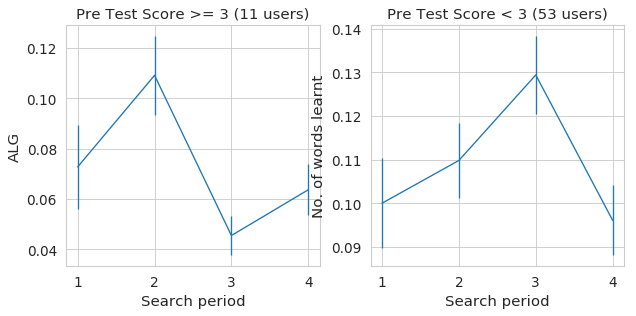

In [400]:
from scipy import stats
plt.figure(figsize=(9, 4), dpi=80)
plt.subplot(1,2,1)
yerr_m = [stats.sem(highiq_alg_dict[str(key)])/(2*10) for  key in np.sort([int(k) for k in highiq_alg_dict.keys()])][1:5]
plt.errorbar(np.arange(4),[np.mean(highiq_alg_dict[str(key)])/10 for  key in np.sort([int(k) for k in highiq_alg_dict.keys()])][1:5], yerr_m)
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("ALG")
plt.xlabel("Search period")
plt.xticks(np.arange(4), ('1', '2', '3', '4'))
plt.title("Pre Test Score >= 3 (11 users)")

plt.subplot(1,2,2)
yerr_m = [stats.sem(lowiq_alg_dict[str(key)])/(2*10) for  key in np.sort([int(k) for k in lowiq_alg_dict.keys()])][1:5]
plt.errorbar(np.arange(4),[np.mean(lowiq_alg_dict[str(key)])/10 for  key in np.sort([int(k) for k in lowiq_alg_dict.keys()])][1:5], yerr_m)
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("No. of words learnt")
plt.xlabel("Search period")
plt.xticks(np.arange(4), ('1', '2', '3', '4'))
plt.title("Pre Test Score < 3 (53 users)")

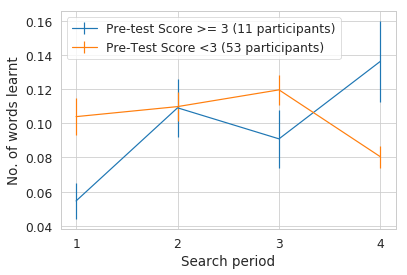

In [418]:
from scipy import stats
# plt.figure(figsize=(5, 4), dpi=80)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)


yerr_m = [stats.sem(highiq_alg_dict[str(key)])/(2*10) for  key in np.sort([int(k) for k in highiq_alg_dict.keys()])][1:5]
line1 = plt.errorbar(np.arange(4),[np.mean(highiq_alg_dict[str(key)])/10 for  key in np.sort([int(k) for k in highiq_alg_dict.keys()])][1:5], yerr_m,)
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("No. of words learnt")
plt.xlabel("Search period")
plt.xticks(np.arange(4), ('1', '2', '3', '4'))
# plt.legend("PTS >= 3 (11 users)", loc='upper left')

# plt.subplot(1,2,2)
yerr_m = [stats.sem(lowiq_alg_dict[str(key)])/(2*10) for  key in np.sort([int(k) for k in lowiq_alg_dict.keys()])][1:5]
line2 = plt.errorbar(np.arange(4),[np.mean(lowiq_alg_dict[str(key)])/10 for  key in np.sort([int(k) for k in lowiq_alg_dict.keys()])][1:5], yerr_m)
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("No. of words learnt")
plt.xlabel("Search period")
plt.xticks(np.arange(4), ('1', '2', '3', '4'))
plt.legend((line1, line2), ("Pre-test Score >= 3 (11 participants)", "Pre-Test Score <3 (53 participants)"), loc='upper left')
plt.savefig("wordslearnt.pdf")
# ("Pre Test Score < 3 (53 users)")

In [259]:
[alg_dict[str(key)] for  key in np.sort([int(k) for k in alg_dict.keys()]) if alg_dict['0'] <3]

[]

In [346]:
def cum_absolute_learning_gain( userId):
    intermid_dict = { }
    topic = get_topic_id(userId)
    topic_terms = get_topic_terms(userId, topic)
    pretest_results = [ r for r in logs.find({ "event" : "SURVEY_PRE_TEST_RESULTS", "userId" :userId})]  
    pretest_results = pretest_results[0] 
    posttest_results = logs.find_one({ "event" : "SURVEY_POST_TEST_RESULTS", "userId" :userId}) 
    score = 0
    for question in topic_terms:  
        qid = "Q-" + str(topic) + "-" + str(question)  
        if int(pretest_results['meta']['data'][qid]) == 3 or int(pretest_results['meta']['data'][qid]) == 4:
            score+=1
    intermid_dict['0']= score
    if score >= 6:
        print("high IQ", userId)

    intermediate_results = [ r for r in logs.find({ "event" : "SURVEY_INTERMEDIATE_TEST_RESULTS", "userId" :userId})]

    for test in intermediate_results:
#         print("session", test['meta']['session'])
        for question in topic_terms:  
            qid = "Q-" + str(topic) + "-" + str(question)  
            if qid in test['meta']['data'].keys():
                if int(test['meta']['data'][qid]) == 3 or int(test['meta']['data'][qid]) == 4:
#                     print("score", score)
                    score+=1
        intermid_dict[str(test['meta']['session'])] = score

        if str(test['meta']['session']) == '3':
            if posttest_results:
                
                for question in topic_terms:  
                    qid = "Q-" + str(topic) + "-" + str(question)
                    if qid in test['meta']['data'].keys():
                        if int(test["meta"]["data"][qid]) == 1 or int(test["meta"]["data"][qid]) == 2:  
                            if int(posttest_results["meta"]["data"][qid]) == 3 or int(posttest_results["meta"]["data"][qid]) == 4:  
                                score += 1
                intermid_dict['4'] = score
            else:
                intermid_dict['4'] = score
    
    for i in range(5):
        if str(i) not in intermid_dict.keys():
#             print("this happened",  "test", str(i) )
            intermid_dict[str(i)] = intermid_dict[str(i-1)]
    return intermid_dict 

In [377]:
cum_alg_dict = {'0':[],'1':[],'2':[],'3':[],'4':[]}
for count, user in enumerate(users):
    print(count)
    print(user)

    dict2 = cum_absolute_learning_gain(user)
    for i in range(5):
        cum_alg_dict[str(i)].append(dict2[str(i)] - dict2[str(0)])


0
5b587dc6efcd5c0001cebd03
1
5b587dc6efcd5c0001cebd03
2
57533f7c483c14000662f391
3
5d3a3b28376aea001a66782d
4
5c9e5a042b3c77001544e975
5
5d26f5eb7aa0b0000138b4ba
('high IQ', '5d26f5eb7aa0b0000138b4ba')
6
5d0a993c6e9965001aeafe67
7
5c9162220791df0001366aa6
8
5d4fe8e3f20feb00190b643c
9
5d63bfff79f8dc0015af6de3
10
5a97081189de8200013eea9b
11
5952a1dc27f8fb00016213bb
12
58fd0de6d66f6400016dc0fd
13
5c742bf8ecf82a0015630ec1
14
5caf6c27b480520012eb741b
15
5d34437867a8ff0019dc0403
('high IQ', '5d34437867a8ff0019dc0403')
16
54a7c951fdf99b7cd759d23e
17
5c3f00de1580e9000122ecb5
18
5b0f27321e55760001b9a8a5
19
5c864b1bd9fe700001023b72
20
5cacf324ea201200013d7807
21
5b0c5ae5641b1200010ee49d
22
59308b35deea010001017c0e
23
5c28ef690091e40001ca5e99
24
5bcdf10432e46700016f8f80
25
595022904df2c40001bf85df
26
5877f454127d7700018b1bdf
27
5bf1de1556a321000106fae0
28
5b09bd6ae9270900013b82be
29
5cd0cdf9731ab00013a73906
30
59f8868e05d1d60001f1464d
31
5b82d4fda284bc000193094c
32
5d91a7c336017c00192a6755
33
5d8

In [376]:
cum_alg_dict

{'0': [0], '1': [1], '2': [2], '3': [5], '4': [7]}

In [374]:
dict2

{'0': 2, '1': 3, '2': 4, '3': 7, '4': 9}

In [378]:
highiq_cum_alg_dict = {'0': [], '1':[],'2':[],'3':[],'4':[]}
highiqerr = [] 
lowiq_cum_alg_dict = {'0': [],'1':[],'2':[],'3':[],'4':[]}
lowiqerr = [] 

for u in range(len(alg_dict['0'])):
    if alg_dict['0'][u] >= 3:
        for i in range(5):
            highiq_cum_alg_dict[str(i)].append(cum_alg_dict[str(i)][u])
    else:
        for i in range(5):
            lowiq_cum_alg_dict[str(i)].append(cum_alg_dict[str(i)][u])

Text(0.5,1,'Pre Test Score < 3 (53 users)')

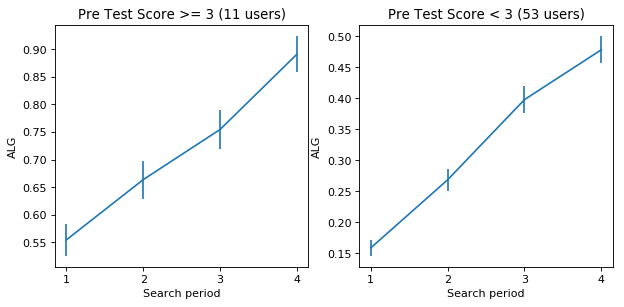

In [309]:
from scipy import stats
plt.figure(figsize=(9, 4), dpi=80)
plt.subplot(1,2,1)
yerr_m = [stats.sem(highiq_cum_alg_dict[str(key)])/(2*10) for  key in np.sort([int(k) for k in highiq_cum_alg_dict.keys()])][1:5]
plt.errorbar(np.arange(4),[np.mean(highiq_cum_alg_dict[str(key)])/10 for  key in np.sort([int(k) for k in highiq_cum_alg_dict.keys()])][1:5], yerr_m)
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("ALG")
plt.xlabel("Search period")
plt.xticks(np.arange(4), ('1', '2', '3', '4'))
plt.title("Pre Test Score >= 3 (11 users)")

plt.subplot(1,2,2)
yerr_m = [stats.sem(lowiq_cum_alg_dict[str(key)])/(2*10) for  key in np.sort([int(k) for k in lowiq_cum_alg_dict.keys()])][1:5]
plt.errorbar(np.arange(4),[np.mean(lowiq_cum_alg_dict[str(key)])/10 for  key in np.sort([int(k) for k in lowiq_cum_alg_dict.keys()])][1:5], yerr_m)
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("ALG")
plt.xlabel("Search period")
plt.xticks(np.arange(4), ('1', '2', '3', '4'))
plt.title("Pre Test Score < 3 (53 users)")

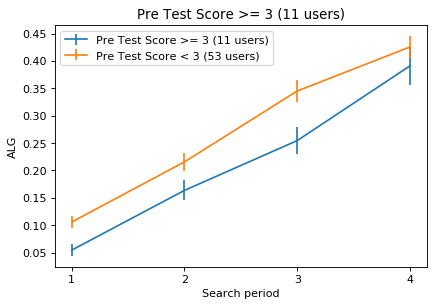

In [379]:
from scipy import stats
plt.figure(figsize=(6, 4), dpi=80)

yerr_m = [stats.sem(highiq_cum_alg_dict[str(key)])/(2*10) for  key in np.sort([int(k) for k in highiq_cum_alg_dict.keys()])][1:5]
line1 = plt.errorbar(np.arange(4),[np.mean(highiq_cum_alg_dict[str(key)])/10 for  key in np.sort([int(k) for k in highiq_cum_alg_dict.keys()])][1:5], yerr_m)
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("ALG")
plt.xlabel("Search period")
plt.xticks(np.arange(4), ('1', '2', '3', '4'))
plt.title("Pre Test Score >= 3 (11 users)")


yerr_m = [stats.sem(lowiq_cum_alg_dict[str(key)])/(2*10) for  key in np.sort([int(k) for k in lowiq_cum_alg_dict.keys()])][1:5]
line2 = plt.errorbar(np.arange(4),[np.mean(lowiq_cum_alg_dict[str(key)])/10 for  key in np.sort([int(k) for k in lowiq_cum_alg_dict.keys()])][1:5], yerr_m)
# plt.legend(loc='lower left', frameon=False)
plt.ylabel("ALG")
plt.xlabel("Search period")
plt.xticks(np.arange(4), ('1', '2', '3', '4'))
plt.legend((line1,line2),("Pre Test Score >= 3 (11 users)","Pre Test Score < 3 (53 users)"))

In [172]:
np.mean(cum_alg_dict['4'])/10

0.5516129032258065

In [210]:
(np.mean(cum_alg_dict['4']) - np.mean(cum_alg_dict['0']))/10

0.4193548387096775

(array([35.,  7.,  9.,  3.,  3.,  1.,  2.,  0.,  1.,  1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

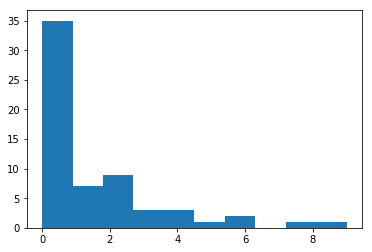

In [256]:
np.sum([1 for p in cum_alg_dict['0'] if p>=3])

11

In [194]:
( np.mean(cum_alg_dict['1']) + np.mean(alg_dict['2'])+ np.mean(alg_dict['3'])+ np.mean(alg_dict['4']))/10

0.4096774193548387

In [195]:
0.4096774193548387 - 0.12903225806451613

0.2806451612903226

In [232]:
def absolute_learning_gain_orig( userId):  
    topic = get_topic_id(userId)
    topic_terms = get_topic_terms(userId, topic)
    pretest_results = [ r for r in logs.find({ "event" : "SURVEY_PRE_TEST_RESULTS", "userId" :userId}).sort("date", -1)]  
    pretest_results = pretest_results[0]  
    intermediate_results = [ r for r in logs.find({ "event" : "SURVEY_INTERMEDIATE_TEST_RESULTS", "userId" :userId}).sort("meta.session", -1)]
    posttest_results = logs.find_one({ "event" : "SURVEY_POST_TEST_RESULTS", "userId" :userId})  
    score = 0  
    for question in topic_terms:  
        qid = "Q-" + str(topic) + "-" + str(question)  
        if posttest_results:
            if int(pretest_results["meta"]["data"][qid]) == 1 or int(pretest_results["meta"]["data"][qid]) == 2:  
                if int(posttest_results["meta"]["data"][qid]) == 3 or int(posttest_results["meta"]["data"][qid]) == 4:  
                    score += 1  
    return score/10

In [233]:
orig_alg_dict = []
for count, user in enumerate(users):
    print(count)
    print(user)

    orig_alg_dict.append(absolute_learning_gain_orig(user))
    

0
5b587dc6efcd5c0001cebd03
1
5b587dc6efcd5c0001cebd03
2
57533f7c483c14000662f391
3
5d3a3b28376aea001a66782d
4
5c9e5a042b3c77001544e975
5
5d26f5eb7aa0b0000138b4ba
6
5d0a993c6e9965001aeafe67
7
5c9162220791df0001366aa6
8
5d4fe8e3f20feb00190b643c
9
5d63bfff79f8dc0015af6de3
10
5a97081189de8200013eea9b
11
5952a1dc27f8fb00016213bb
12
58fd0de6d66f6400016dc0fd
13
5c742bf8ecf82a0015630ec1
14
5caf6c27b480520012eb741b
15
5d34437867a8ff0019dc0403
16
54a7c951fdf99b7cd759d23e
17
5c3f00de1580e9000122ecb5
18
5b0f27321e55760001b9a8a5
19
5c864b1bd9fe700001023b72
20
5cacf324ea201200013d7807
21
5b0c5ae5641b1200010ee49d
22
59308b35deea010001017c0e
23
5c28ef690091e40001ca5e99
24
5bcdf10432e46700016f8f80
25
595022904df2c40001bf85df
26
5877f454127d7700018b1bdf
27
5bf1de1556a321000106fae0
28
5b09bd6ae9270900013b82be
29
5cd0cdf9731ab00013a73906
30
59f8868e05d1d60001f1464d
31
5b82d4fda284bc000193094c
32
5d91a7c336017c00192a6755
33
5d8e3a178b0c840017736451
34
59bb884a3c45a10001ccc4f7
35
5d235fa4c9b2ee00190ed9af
36

In [234]:
def realized_potential_learning(userId):  
    pretest_results = [ r for r in logs.find({ "event" : "SURVEY_PRE_TEST_RESULTS", usersIdentifier(userId) :userId}).sort("date", -1)][0]  
    posttest_results = logs.find_one({ "event" : "SURVEY_POST_TEST_RESULTS", usersIdentifier(userId) :userId})  
    max_gain = 0  

    for question in range(0,10):  
        qid = "Q-" + str(topic) + "-" + str(question)  

        if int(pretest_results["meta"]["results"][qid]) == 1 or int(pretest_results["meta"]["results"][qid]) == 2:  
            max_gain += 1    
    max_gain /= 10  
    gain = absolute_learning_gain(userId)  

    return gain/max_gain

0.37096774193548393

In [329]:
cum_absolute_learning_gain("5b587dc6efcd5c0001cebd03")


{'0': 2, '1': 3, '2': 4, '3': 7, '4': 9}

In [330]:
absolute_learning_gain("5b587dc6efcd5c0001cebd03")

{'0': 2, '1': 1, '2': 1, '3': 3, '4': 2}

In [344]:
absolute_learning_gain_fine("5b587dc6efcd5c0001cebd03")

{'0': 4, '1': 1, '2': 1, '3': 5, '4': 4}

In [358]:
cum_absolute_learning_gain_fine("5b587dc6efcd5c0001cebd03")

{'0': 4, '1': 5, '2': 6, '3': 11, '4': 15}

In [365]:
rpl_dict = {'0': [], '1':[],'2':[],'3':[],'4':[]}
for user in users:
    for i in range(1,5):
        if cum_absolute_learning_gain_fine(user)[str(i-1)] == 20:
            rpl_dict[str(i)].append(1)
        else:
            rpl_dict[str(i)].append(absolute_learning_gain_fine(user)[str(i)]/(20-cum_absolute_learning_gain_fine(user)[str(i-1)]))
            

In [371]:
rpl_dict

{'0': [],
 '1': [0.0625,
  0.0625,
  0.0,
  0.4,
  0.0,
  0.0,
  0.0,
  0.05555555555555555,
  0.6,
  0.05263157894736842,
  0.3,
  0.0,
  0.0,
  0.1,
  0.05555555555555555,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.3888888888888889,
  0.0,
  0.1,
  0.0,
  0.2,
  0.0,
  0.0,
  0.0,
  0.05263157894736842,
  0.0,
  0.0,
  0.1,
  0.05,
  0.16666666666666666,
  0.05,
  0.0,
  0.0,
  0.1,
  0.09090909090909091,
  0.15384615384615385,
  0.2222222222222222,
  0.0,
  0.125,
  0.0,
  0.05,
  0.0,
  0.0,
  0.0,
  0.0,
  0.05,
  0.0,
  0.05555555555555555,
  0.0,
  0.05,
  0.1,
  0.1,
  0.05,
  0.06666666666666667,
  0.10526315789473684,
  0.0625,
  0.0,
  0.0],
 '2': [0.06666666666666667,
  0.06666666666666667,
  0.0,
  0.08333333333333333,
  0.0,
  0.2222222222222222,
  0.0,
  0.058823529411764705,
  0.625,
  0.1111111111111111,
  0.2857142857142857,
  0.0,
  0.0,
  0.3888888888888889,
  0.058823529411764705,
  0.2857142857142857,
  0.0,
  0.05,
  0.0,
  0.0,
  0.09090909090909091,
  0.05,
  0.222

In [361]:
def absolute_learning_gain_fine( userId):
    intermid_dict = { }
    topic = get_topic_id(userId)
    topic_terms = get_topic_terms(userId, topic)
    pretest_results = [ r for r in logs.find({ "event" : "SURVEY_PRE_TEST_RESULTS", "userId" :userId}).sort("date", -1)]  
    pretest_results = pretest_results[0] 
    posttest_results = logs.find_one({ "event" : "SURVEY_POST_TEST_RESULTS", "userId" :userId}) 
    score = 0
    for question in topic_terms:  
        qid = "Q-" + str(topic) + "-" + str(question)  
        if int(pretest_results['meta']['data'][qid]) == 3:
            score+=1
        if int(pretest_results['meta']['data'][qid]) == 4:
            score+=2
    intermid_dict['0']= score
    
    intermediate_results = [ r for r in logs.find({ "event" : "SURVEY_INTERMEDIATE_TEST_RESULTS", "userId" :userId})]
    for test in intermediate_results:
        score = 0
        for question in topic_terms:  
            qid = "Q-" + str(topic) + "-" + str(question)  
            if qid in test['meta']['data'].keys():
                if int(test['meta']['data'][qid]) == 3:
                    score+=1
                if int(test['meta']['data'][qid]) == 4:
                    score+=2
        intermid_dict[str(test['meta']['session'])] = score
        
        if str(test['meta']['session']) == '3':
            if posttest_results:
                score = 0
                for question in topic_terms:  
                    qid = "Q-" + str(topic) + "-" + str(question)
                    if qid in test['meta']['data'].keys():
                        if int(test["meta"]["data"][qid]) == 1 or int(test["meta"]["data"][qid]) == 2:  
                            if int(posttest_results["meta"]["data"][qid]) == 3:
                                score += 1
                            if int(posttest_results["meta"]["data"][qid]) == 4:  
                                score += 2
                intermid_dict['4'] = score
            else:
                intermid_dict['4'] = 0
    
    for i in range(5):
        if str(i) not in intermid_dict.keys():
#             print("this happened",  "test", str(i) )
            intermid_dict[str(i)] = 0
    return intermid_dict 

In [362]:
def cum_absolute_learning_gain_fine(user):
    alg_fine = absolute_learning_gain_fine(user)
    cum_alg_fine = {'0': [], '1':[],'2':[],'3':[],'4':[]}
    c = 0
    for i in range(5):
        c+=alg_fine[str(i)]
        cum_alg_fine[str(i)] = c
    return cum_alg_fine

In [12]:
all_ids = pickle.load(open("retrieved_docs.pkl", 'rb'))
all_docs = pickle.load(open("all_docs.pkl", 'rb'))

In [ ]:
import subprocess
import pickle
from tqdm.auto import tqdm
def find_doc_id(internal_id):
    dump_index_path = "/ssd2/arthur/Indri-5.14-src/dumpindex/dumpindex"
    index_path = "/ssd2/arthur/TRECCAR/data/indexes/docs_with_expanded_relevants"
    cmd = "{} {} dn {}".format(dump_index_path, index_path, internal_id)
    output = subprocess.check_output(cmd.split()).decode("utf-8")
    return output

id_mapper = dict()
all_ids = pickle.load(open("all_docs.pkl", 'rb'))
for i_id in tqdm(all_ids):
    doc_id = find_doc_id(i_id)
    id_mapper[i_id] = doc_id

In [9]:
pickle.dump(id_mapper, open("internal_id_mapper.pkl", 'wb'))

In [10]:
len(id_mapper)

3513